## 1. Sınıf Dağılım Analizi

/tmp/ipykernel_126870/3019268958.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


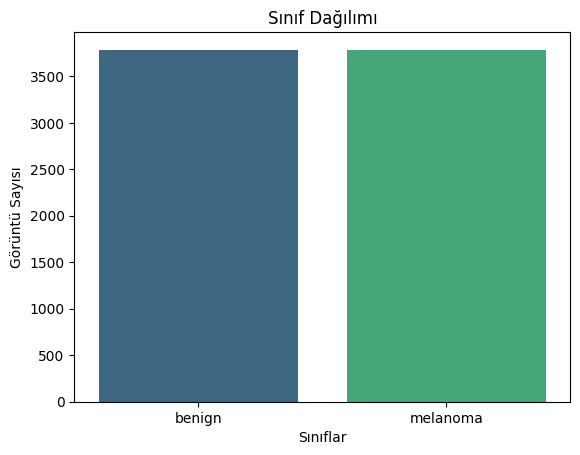

Benign oranı: 49.99%


/tmp/ipykernel_126870/3019268958.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  benign_ratio = class_counts[0] / class_counts.sum()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/mnt/c/Users/frdnp/Desktop/Projects/dermoscopic-melanoma-classification/data/splits/train_val_dataset_2.csv')  # image_path, label (0=benign, 1=malignant)
df['image_path'] = df['image'].apply(lambda x: f"/mnt/c/Users/frdnp/Desktop/Projects/dermoscopic-melanoma-classification/data/raw/train/images/{x}.jpg")
class_counts = df['label'].value_counts().sort_index()
class_counts.index = ['benign', 'melanoma']

sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title("Sınıf Dağılımı")
plt.ylabel("Görüntü Sayısı")
plt.xlabel("Sınıflar")
plt.show()

benign_ratio = class_counts[0] / class_counts.sum()
print(f"Benign oranı: {benign_ratio:.2%}")


## 2. Görüntü Kalitesi Analizi

In [ ]:
import os
import pandas as pd
import torch
import torchvision.transforms as T
from PIL import Image
from skimage.io import imread
from skimage import img_as_float
from skimage.restoration import estimate_sigma
from tqdm import tqdm
import piq
import numpy as np

# Veriyi yükle
image_paths = df['image_path'].tolist()

transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

results = []

for img_path in tqdm(image_paths, desc="Evaluating BRISQUE & noise"):
    img_pil = Image.open(img_path).convert("RGB")
    img_tensor = transform(img_pil).unsqueeze(0)

    brisque_score = piq.brisque(img_tensor, data_range=1.0).item()

    # Gürültü tahmini (skimage ile)
    img_rgb = imread(img_path)
    img_float = img_as_float(img_rgb)
    sigma = estimate_sigma(img_float, channel_axis=-1 if img_float.ndim == 3 else None)
    noise_estimate = np.mean(sigma)

    results.append({
        'image_path': img_path,
        'brisque_score': brisque_score,
        'noise_estimate': noise_estimate
    })



quality_df = pd.DataFrame(results)


Evaluating BRISQUE & noise: 100%|██████████| 7571/7571 [30:39<00:00,  4.11it/s]  


In [14]:
quality_df

,image_path,brisque_score,noise_estimate
0,/mnt/c/Users/frdnp/Desktop/Projects/dermoscopi...,23.951233,0.001226
1,/mnt/c/Users/frdnp/Desktop/Projects/dermoscopi...,13.855896,0.001510
2,/mnt/c/Users/frdnp/Desktop/Projects/dermoscopi...,2.207886,0.001696
3,/mnt/c/Users/frdnp/Desktop/Projects/dermoscopi...,12.641907,0.001477
4,/mnt/c/Users/frdnp/Desktop/Projects/dermoscopi...,8.689270,0.001590
...,...,...,...
7566,/mnt/c/Users/frdnp/Desktop/Projects/dermoscopi...,19.362976,0.001324
7567,/mnt/c/Users/frdnp/Desktop/Projects/dermoscopi...,8.861267,0.001356
7568,/mnt/c/Users/frdnp/Desktop/Projects/dermoscopi...,14.021545,0.001477
7569,/mnt/c/Users/frdnp/Desktop/Projects/dermoscopi...,10.546997,0.001864


In [16]:
def classify_image_quality(brisque, noise):
    if brisque < 30 and noise < 0.01:
        return 'high'
    elif brisque < 50 and noise < 0.03:
        return 'medium'
    else:
        return 'low'

quality_df['quality_class'] = quality_df.apply(lambda row: classify_image_quality(row['brisque_score'], row['noise_estimate']), axis=1)


In [19]:
quality_df['quality_class'].value_counts()

quality_class
high      6050
medium    1250
low        271
Name: count, dtype: int64

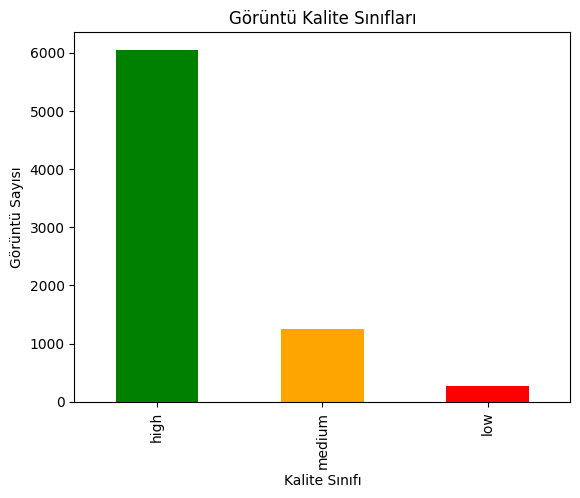

In [18]:
quality_df['quality_class'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title("Görüntü Kalite Sınıfları")
plt.xlabel("Kalite Sınıfı")
plt.ylabel("Görüntü Sayısı")
plt.show()

In [ ]:
quality_df.to_csv("../experiments/results/image_quality_metrics.csv", index=False)